In [1]:
import xarray as xr
import numpy as np
import os
import sys
import matplotlib.pyplot as plt

In [2]:
#
# This is the latlon arrays that go with the refl data
#
input_dir = '/glade/work/hardt/ds612'
#
latlon_filename = 'model2_latlon_coord.nc'
refl_filename = 'model2_0minuteAfterHour_3D_refl_shuffled.nc'
W_filename = 'model2_3D_W_shuffled.nc'

latlonFile = os.path.join(input_dir, latlon_filename)
reflFile = os.path.join(input_dir, refl_filename)
WFile = os.path.join(input_dir, W_filename)

In [16]:
latlon_ds = xr.open_mfdataset(latlonFile, combine='by_coords')
lat = latlon_ds.XLAT[0,:,:].values
lon = latlon_ds.XLONG[0,:,:].values

In [4]:
refl_ds = xr.open_mfdataset(reflFile, combine='by_coords')

In [5]:
print(refl_ds)

<xarray.Dataset>
Dimensions:    (dim_0: 4896, dim_1: 10, dim_2: 256, dim_3: 256)
Dimensions without coordinates: dim_0, dim_1, dim_2, dim_3
Data variables:
    REFL_10CM  (dim_0, dim_1, dim_2, dim_3) float32 dask.array<chunksize=(4896, 10, 256, 256), meta=np.ndarray>
    XTIME      (dim_0) datetime64[ns] dask.array<chunksize=(4896,), meta=np.ndarray>


In [6]:
image_number = 200
refl_height = 0
W_height = 3
label_feature_thresh = 0.0001
apply_thresh = True

In [7]:
ref_t = refl_ds.XTIME[image_number].values

In [8]:
print(ref_t)

2015-05-15T12:00:00.000000000


In [9]:
W_ds = xr.open_mfdataset(WFile, combine='by_coords')

In [10]:
W_t = W_ds.XTIME[image_number].values

In [11]:
print(W_t)
year = str(W_t)[0:4]
month = str(W_t)[5:7]
day = str(W_t)[8:10]
hour = str(W_t)[11:13]
minute = str(W_t)[14:16]
full_datetime_string = year + month + day + " " + hour + ':' + minute + ' ' + 'UTC'
print(full_datetime_string)

2015-05-15T12:00:00.000000000
20150515 12:00 UTC


In [12]:
refl = refl_ds.REFL_10CM[image_number,refl_height,:,:].values
#refl = refl_ds.REFL_10CM[image_number,:,:,:].values.max(axis=0)

In [13]:
print(refl.shape)

(256, 256)


In [14]:
#W = W_ds.W[image_number,W_height,:,:].values
W = W_ds.W[image_number,:,:,:].values.max(axis=0)
if apply_thresh:
    W[refl<label_feature_thresh] = -99.0

In [15]:
print(W.shape)

(256, 256)


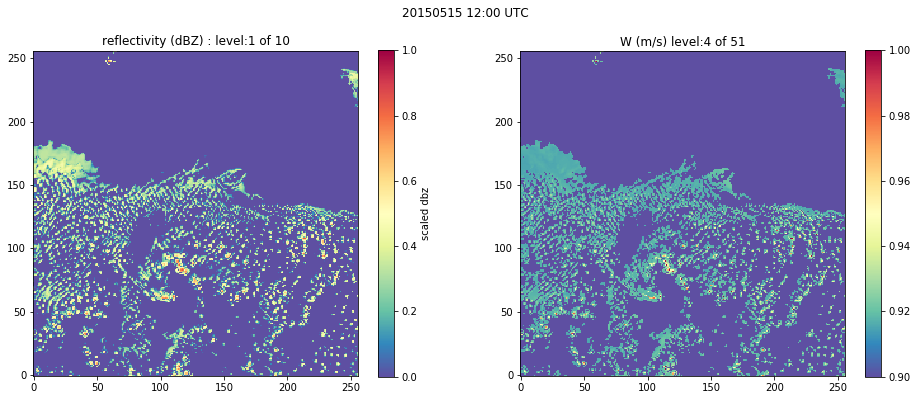

In [17]:
cmap = plt.cm.Spectral_r


fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,6)) 
fig.suptitle(full_datetime_string)
max_ref = np.amax(refl[:,:])
p_ref = np.percentile(refl[:,:], 99.9)

ref_p = ax1.imshow(refl, cmap=cmap,origin='lower')
ax1.set_title("reflectivity (dBZ) : level:" + str(refl_height+1) + " of 10")
ref_p.set_clim(vmin=0, vmax=1.0)
fig.colorbar(ref_p, ax=ax1, orientation='vertical', label='scaled dbz')

min_W = np.amin(W[:,:])
max_W = np.amax(W[:,:])
p_W = np.percentile(W[:,:], 99.9)

W_p = ax2.imshow(W, cmap=cmap,origin='lower')
ax2.set_title("W (m/s) level:" + str(W_height+1) + " of 51" )
#maxW.set_clim(vmin=0.0, vmax=max_W)
#W_p.set_clim(vmin=0.0,vmax=p_W)
W_p.set_clim(vmin=0.9,vmax=1.0)
#W_p.set_clim()
fig.colorbar(W_p, ax=ax2)


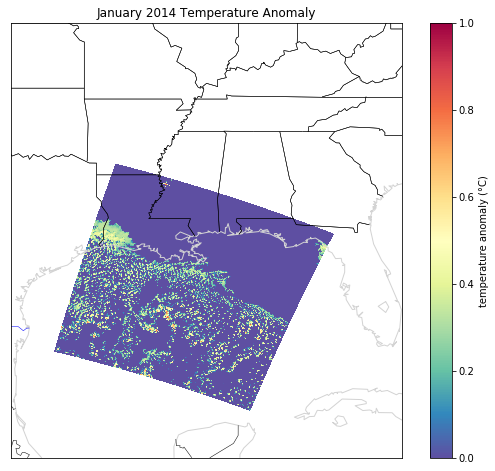

In [18]:
#
# basemap example
#

from mpl_toolkits.basemap import Basemap

fig = plt.figure(figsize=(10, 8))
m = Basemap(projection='cyl', resolution='l',
            llcrnrlat=20, urcrnrlat=40,
            llcrnrlon=-98,urcrnrlon=-80,)
#m.shadedrelief(scale=0.5)
m.pcolormesh(lon, lat, refl,
             latlon=True, cmap=cmap)
plt.clim(0,1)
m.drawcoastlines(color='lightgray')
m.drawcountries(color='blue')
m.drawstates(color='black')

plt.title('January 2014 Temperature Anomaly')
plt.colorbar(label='temperature anomaly (°C)')


In [ ]:
#
# cartopy exmaple
#

import cartopy.crs as ccrs
import cartopy.feature as cf
import matplotlib.pyplot as plt
import numpy as np

cmap = plt.cm.Spectral_r

extent = [-100, -80, 20, 35]
#extent = [-120, -70, 20, 50]

cmap = plt.cm.Spectral_r
plt.figure(figsize=(12, 6))


proj = ccrs.LambertConformal(central_latitude = 25, 
                             central_longitude = 265, 
                             standard_parallels = (25, 25))

ax = plt.axes(projection = proj)
#plt.pcolormesh(lon, lat, refl, cmap=cmap, transform = ccrs.PlateCarree())
plt.contourf(lon, lat, refl, cmap=cmap, transform = ccrs.PlateCarree())

#
# Not sure how this is different from cf.STATES
#
#ax.add_feature(cf.NaturalEarthFeature(
#               category='cultural',
#               name='admin_1_states_provinces_lines',
#               scale='50m',
#               facecolor='none', edgecolor='black'))

#
# This can be turned off and the domain will be data driven
#
ax.set_extent(extent)

ax.coastlines('50m', edgecolor='black')
#ax.add_feature(cf.BORDERS, edgecolor='black')
ax.add_feature(cf.STATES, edgecolor='black', linewidth=0.5)
ax.add_feature(cf.OCEAN)
ax.add_feature(cf.LAND, facecolor='beige', edgecolor='none')
ax.add_feature(cf.LAKES, edgecolor='black')
#ax.add_feature(cf.RIVERS)

plt.colorbar(label='Reflectivity (dBZ)')
plt.show()